# Pipeline draft

In [4]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

import bbrl_gymnasium

from pmind.algorithms import DQN, DDPG, TD3, ContinuousDeterministicActor
from pmind.losses import dqn_compute_critic_loss, ddqn_compute_critic_loss
from pmind.training import (
    run_dqn,
    run_ddpg,
    run_td3,
    run_td3_offline,
    chatgpt_faster_run_td3,
)
from pmind.replay import (
    collect_policy_transitions,
    collect_uniform_transitions,
    # collect_uniform_transitions_2,
    mix_transitions,
    test_rb_compositions,
)

from pmind.config.loader import load_config

bbrl_utils.setup()

cfg = load_config("bbrl_example")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# setup_tensorboard("./outputs/tblogs")

# Obtain transitions

In [5]:
ENV_NAME = [
    "CartPoleContinuous-v1",
    "Pendulum-v1",
    "MountainCarContinuous-v0",
    "LunarLander-v3",
][0]
BUFFER_SIZE = 100_000
PROPORTIONS = np.linspace(0, 1, 10)

## Best policy

Get the best policy and get transitions with it

In [ ]:
cfg_td3_best = OmegaConf.create(cfg.td3)

# accelerate for the sake of test:
cfg_td3_best.algorithm.max_epochs = 11_000
cfg_td3_best.algorithm.learning_starts = 1000

td3 = TD3(cfg_td3_best)
policies = run_td3(td3, save_model_at_rewards=[100, 200, 300, 400, 500])
# td3.best_policy.load_model("../models/CartPoleContinuous-v1-model-best.pt")
# td3.visualize_best()
best_policy_agent = td3.best_policy

Matplotlib backend: inline


  0%|          | 0/11000 [00:00<?, ?it/s]

Saving w/ reward: 113.5
Saving w/ reward: 225.1999969482422
Saving w/ reward: 375.79998779296875
Saving w/ reward: 500.0


In [ ]:
best_policy_agent = td3.best_policy

In [ ]:
type(td3.best_policy)

In [ ]:
# td3.best_policy.save_model()

In [10]:
replay_buffers = {}
for k, policy in policies.items():
    replay_buffers[k] = collect_policy_transitions(policy, ENV_NAME, BUFFER_SIZE)

In [11]:
rb_best = collect_policy_transitions(
    best_policy_agent, ENV_NAME, buffer_size=BUFFER_SIZE
)
print(f"Replay buffer with {rb_best.size()} transitions")

Replay buffer with 100000 transitions


## Uniform exploration

In [12]:
# rb_unif = collect_uniform_transitions(ENV_NAME, buffer_size=BUFFER_SIZE)
rb_unif = collect_uniform_transitions(ENV_NAME)
print(f"Replay buffer with {rb_unif.size()} transitions")

100%|██████████| 100000/100000 [00:06<00:00, 15280.80it/s]

Replay buffer with 100000 transitions


Milos: dict_keys(['env/env_obs', 'env/terminated', 'env/truncated', 'env/done', 'env/reward', 'env/cumulated_reward', 'env/timestep', 'action'])

Vlad: dict_keys(['env/env_obs', 'action', 'env/timestep', 'env/terminated', 'env/truncated', 'env/done', 'env/reward', 'env/cumulated_reward'])

# Offline learning on mixed replay buffer

In [ ]:
cfg_td3_offline = OmegaConf.create(cfg.td3)

# accelerate for the sake of test:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000

# we don't care about when learning starts for offline:
cfg_td3_offline.algorithm.learning_starts = None

# TODO: apply no noise to actions during learning or it's independent?
# cfg_td3_offline.action_noise = 0
# cfg_td3_offline.target_policy_noise = 0

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

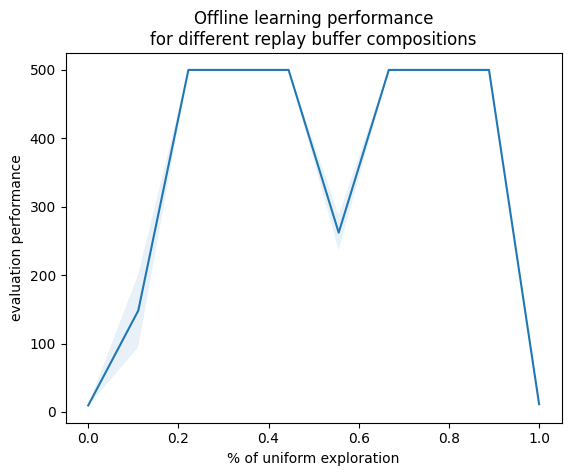

In [ ]:
perfs = test_rb_compositions(
    rb_unif=rb_unif,
    rb_exploit=rb_best,
    buffer_size=BUFFER_SIZE,
    proportions=PROPORTIONS,
    agent_constructor=TD3,
    cfg=cfg_td3_offline,
    offline_run=run_td3_offline,
)

In [ ]:
performances = {}
for k, replay_buffer in replay_buffers.items():
    performances[k] = test_rb_compositions(
        rb_unif=rb_unif,
        rb_exploit=replay_buffer,
        buffer_size=BUFFER_SIZE,
        proportions=PROPORTIONS,
        agent_constructor=TD3,
        cfg=cfg_td3_offline,
        offline_run=run_td3_offline,
        plot=False,
    )
print(performances)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

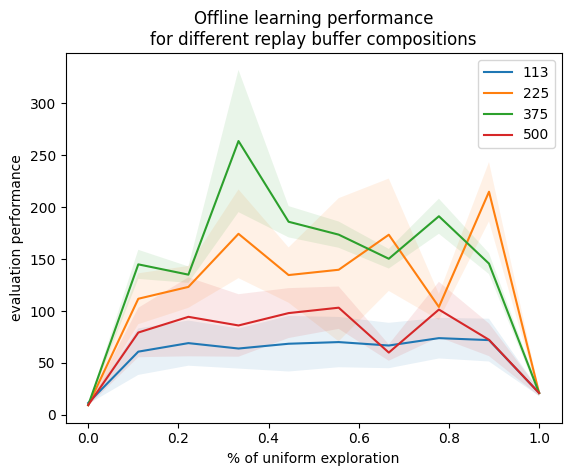

In [ ]:
def plot_perf_vs_rb_composition_from_dict(proportions, perf_dict, fig_name=None):
    plt.figure()

    for label, performances in perf_dict.items():
        means = np.array([perf[-1].mean().item() for perf in performances])
        stds = np.array([perf[-1].std().item() for perf in performances])

        plt.plot(proportions, means, label=label)
        plt.fill_between(
            proportions,
            means - stds,
            means + stds,
            alpha=0.1,
        )

    plt.title("Offline learning performance\nfor different replay buffer compositions")
    plt.xlabel("% of uniform exploration")
    plt.ylabel("evaluation performance")
    plt.legend()
    if fig_name:
        plt.savefig(fig_name)
    plt.show()


plot_perf_vs_rb_composition_from_dict(
    PROPORTIONS, performances, fig_name=f"{ENV_NAME}-offline-diff-best-policies-3x.pdf"
)